##  Classifying audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo<br/>
<br/>

This notebook is part of the project "Urban sounds classification with Covnolutional Neural Networks" on [my Github](https://github.com/GorillaBus/urban-audio-classifier).<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

# Basic CNN Model - Log-Mel Spectrograms

To compare the results from the previous notebook between MFCC and Log-Mel Spectrograms features I'm going to replicate the same basic CNN model training procedure of that notebook.
<br/>

INDEX

1. Data preparation: features + metadata
2. A basic CNN model
4. Model evaluation
7. Conclusion
8. Next


<br/>
<br/>

#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

#### * Setup

In [10]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = "C:\\dev\\volgemobile\\train\\data\\UrbanSound8K\\metadata\\UrbanSound8K.csv"
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [9]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

#### * Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Mel Spectrogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.<br/>
<br/>

In [11]:
# Pre-processed MFCC coefficients
X = np.load("data/X-mel_spec.npy")
y = np.load("data/y-mel_spec.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

### 1. Data preparation: features + metadata

#### 1.1 Train / Test split
Note that we are using the same index order for both the Mel Spectrogram arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [12]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### 1.2 One hot encode labels

In [13]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [14]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

## 2. Basic CNN network

We are using the exact same architecture than the previous notebook.
<br/>

#### 2.1 Model definition



In [15]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### 2.2 Setup model optimizer and loss function

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters to start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [17]:
adam = Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 172, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 38, 172, 32)       0         
                                                                 
 batch_normalization (BatchN  (None, 38, 172, 32)      128       
 ormalization)                                                   
                                                                 
 spatial_dropout2d (SpatialD  (None, 38, 172, 32)      0         
 ropout2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 170, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 170, 32)       0

#### 2.3 Training the model

With Log-Mel Spectrograms it was possible to train for some more epochs before overfitting compared to the previous experiment with MFCC.
<br/>
<br/>

In [18]:
num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/360
51/51 [==============================] - ETA: 0s - loss: 2.0801 - accuracy: 0.2710
Epoch 1: val_loss improved from inf to 2.37417, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 67s 1s/step - loss: 2.0801 - accuracy: 0.2710 - val_loss: 2.3742 - val_accuracy: 0.1201
Epoch 2/360
51/51 [==============================] - ETA: 0s - loss: 1.8406 - accuracy: 0.3781
Epoch 2: val_loss did not improve from 2.37417
51/51 [==============================] - 79s 2s/step - loss: 1.8406 - accuracy: 0.3781 - val_loss: 2.5526 - val_accuracy: 0.1269
Epoch 3/360
51/51 [==============================] - ETA: 0s - loss: 1.7464 - accuracy: 0.4120
Epoch 3: val_loss did not improve from 2.37417
51/51 [==============================] - 89s 2s/step - loss: 1.7464 - accuracy: 0.4120 - val_loss: 2.8372 - val_accuracy: 0.1252
Epoch 4/360
51/51 [==============================] - ETA: 0s - loss: 1.6846 - accuracy: 0.4356
Epoch 4: val_loss did

50/51 [============================>.] - ETA: 1s - loss: 1.2456 - accuracy: 0.6006
Epoch 26: val_loss improved from 1.13766 to 1.12578, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 83s 2s/step - loss: 1.2460 - accuracy: 0.6005 - val_loss: 1.1258 - val_accuracy: 0.6672
Epoch 27/360
51/51 [==============================] - ETA: 0s - loss: 1.2457 - accuracy: 0.5972
Epoch 27: val_loss improved from 1.12578 to 1.12569, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 80s 2s/step - loss: 1.2457 - accuracy: 0.5972 - val_loss: 1.1257 - val_accuracy: 0.6792
Epoch 28/360
51/51 [==============================] - ETA: 0s - loss: 1.2309 - accuracy: 0.6047
Epoch 28: val_loss improved from 1.12569 to 1.10818, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 83s 2s/step - loss: 1.2309 - accuracy: 0.6047 - val_loss:

51/51 [==============================] - ETA: 0s - loss: 1.0472 - accuracy: 0.6762
Epoch 50: val_loss improved from 0.93135 to 0.91357, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 87s 2s/step - loss: 1.0472 - accuracy: 0.6762 - val_loss: 0.9136 - val_accuracy: 0.7427
Epoch 51/360
51/51 [==============================] - ETA: 0s - loss: 1.0323 - accuracy: 0.6862
Epoch 51: val_loss improved from 0.91357 to 0.90980, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 86s 2s/step - loss: 1.0323 - accuracy: 0.6862 - val_loss: 0.9098 - val_accuracy: 0.7410
Epoch 52/360
51/51 [==============================] - ETA: 0s - loss: 1.0362 - accuracy: 0.6834
Epoch 52: val_loss improved from 0.90980 to 0.90869, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 86s 2s/step - loss: 1.0362 - accuracy: 0.6834 - val_loss:

51/51 [==============================] - 86s 2s/step - loss: 0.9146 - accuracy: 0.7267 - val_loss: 0.7935 - val_accuracy: 0.7787
Epoch 75/360
51/51 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.7315
Epoch 75: val_loss improved from 0.79347 to 0.78057, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 87s 2s/step - loss: 0.9067 - accuracy: 0.7315 - val_loss: 0.7806 - val_accuracy: 0.7976
Epoch 76/360
51/51 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.7339
Epoch 76: val_loss improved from 0.78057 to 0.77952, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 86s 2s/step - loss: 0.9095 - accuracy: 0.7339 - val_loss: 0.7795 - val_accuracy: 0.7890
Epoch 77/360
51/51 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.7326
Epoch 77: val_loss improved from 0.77952 to 0.77764, saving model to C:\dev\vol

51/51 [==============================] - 87s 2s/step - loss: 0.8089 - accuracy: 0.7725 - val_loss: 0.7110 - val_accuracy: 0.8165
Epoch 101/360
51/51 [==============================] - ETA: 0s - loss: 0.8087 - accuracy: 0.7723
Epoch 101: val_loss did not improve from 0.71096
51/51 [==============================] - 87s 2s/step - loss: 0.8087 - accuracy: 0.7723 - val_loss: 0.7126 - val_accuracy: 0.8096
Epoch 102/360
51/51 [==============================] - ETA: 0s - loss: 0.8055 - accuracy: 0.7664
Epoch 102: val_loss improved from 0.71096 to 0.70478, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 88s 2s/step - loss: 0.8055 - accuracy: 0.7664 - val_loss: 0.7048 - val_accuracy: 0.8113
Epoch 103/360
51/51 [==============================] - ETA: 0s - loss: 0.8006 - accuracy: 0.7657
Epoch 103: val_loss improved from 0.70478 to 0.69385, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==================

51/51 [==============================] - 88s 2s/step - loss: 0.7378 - accuracy: 0.7874 - val_loss: 0.6386 - val_accuracy: 0.8370
Epoch 127/360
51/51 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.7879
Epoch 127: val_loss did not improve from 0.63668
51/51 [==============================] - 88s 2s/step - loss: 0.7380 - accuracy: 0.7879 - val_loss: 0.6511 - val_accuracy: 0.8285
Epoch 128/360
51/51 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.7859
Epoch 128: val_loss did not improve from 0.63668
51/51 [==============================] - 88s 2s/step - loss: 0.7475 - accuracy: 0.7859 - val_loss: 0.6503 - val_accuracy: 0.8285
Epoch 129/360
51/51 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.7913
Epoch 129: val_loss did not improve from 0.63668
51/51 [==============================] - 88s 2s/step - loss: 0.7318 - accuracy: 0.7913 - val_loss: 0.6391 - val_accuracy: 0.8250
Epoch 130/360
51/51 [=========================

Epoch 154/360
51/51 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.8106
Epoch 154: val_loss did not improve from 0.59041
51/51 [==============================] - 88s 2s/step - loss: 0.6733 - accuracy: 0.8106 - val_loss: 0.5916 - val_accuracy: 0.8405
Epoch 155/360
51/51 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.8079
Epoch 155: val_loss did not improve from 0.59041
51/51 [==============================] - 88s 2s/step - loss: 0.6750 - accuracy: 0.8079 - val_loss: 0.5958 - val_accuracy: 0.8456
Epoch 156/360
51/51 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.8088
Epoch 156: val_loss improved from 0.59041 to 0.58315, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 88s 2s/step - loss: 0.6704 - accuracy: 0.8088 - val_loss: 0.5832 - val_accuracy: 0.8456
Epoch 157/360
51/51 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.8123
Epo

Epoch 181/360
51/51 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.8241
Epoch 181: val_loss did not improve from 0.53943
51/51 [==============================] - 88s 2s/step - loss: 0.6307 - accuracy: 0.8241 - val_loss: 0.5484 - val_accuracy: 0.8491
Epoch 182/360
51/51 [==============================] - ETA: 0s - loss: 0.6318 - accuracy: 0.8246
Epoch 182: val_loss did not improve from 0.53943
51/51 [==============================] - 88s 2s/step - loss: 0.6318 - accuracy: 0.8246 - val_loss: 0.5526 - val_accuracy: 0.8559
Epoch 183/360
51/51 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.8270
Epoch 183: val_loss did not improve from 0.53943
51/51 [==============================] - 88s 2s/step - loss: 0.6220 - accuracy: 0.8270 - val_loss: 0.5494 - val_accuracy: 0.8473
Epoch 184/360
51/51 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.8279
Epoch 184: val_loss did not improve from 0.53943
51/51 [======================

51/51 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.8362
Epoch 208: val_loss did not improve from 0.51057
51/51 [==============================] - 88s 2s/step - loss: 0.5830 - accuracy: 0.8362 - val_loss: 0.5146 - val_accuracy: 0.8593
Epoch 209/360
51/51 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.8374
Epoch 209: val_loss did not improve from 0.51057
51/51 [==============================] - 103s 2s/step - loss: 0.5890 - accuracy: 0.8374 - val_loss: 0.5120 - val_accuracy: 0.8611
Epoch 210/360
50/51 [============================>.] - ETA: 1s - loss: 0.5892 - accuracy: 0.8350
Epoch 210: val_loss did not improve from 0.51057
51/51 [==============================] - 81s 2s/step - loss: 0.5899 - accuracy: 0.8348 - val_loss: 0.5412 - val_accuracy: 0.8559
Epoch 211/360
51/51 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.8377
Epoch 211: val_loss did not improve from 0.51057
51/51 [==============================] - 7

Epoch 236/360
51/51 [==============================] - ETA: 0s - loss: 0.5406 - accuracy: 0.8502
Epoch 236: val_loss did not improve from 0.47665
51/51 [==============================] - 76s 1s/step - loss: 0.5406 - accuracy: 0.8502 - val_loss: 0.4794 - val_accuracy: 0.8662
Epoch 237/360
51/51 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.8473
Epoch 237: val_loss improved from 0.47665 to 0.47565, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 88s 2s/step - loss: 0.5464 - accuracy: 0.8473 - val_loss: 0.4757 - val_accuracy: 0.8628
Epoch 238/360
51/51 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.8487
Epoch 238: val_loss did not improve from 0.47565
51/51 [==============================] - 77s 2s/step - loss: 0.5481 - accuracy: 0.8487 - val_loss: 0.4822 - val_accuracy: 0.8679
Epoch 239/360
51/51 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.8507
Epo

51/51 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.8555
Epoch 264: val_loss did not improve from 0.45710
51/51 [==============================] - 77s 2s/step - loss: 0.5186 - accuracy: 0.8555 - val_loss: 0.4618 - val_accuracy: 0.8696
Epoch 265/360
51/51 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.8573
Epoch 265: val_loss improved from 0.45710 to 0.45575, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 82s 2s/step - loss: 0.5164 - accuracy: 0.8573 - val_loss: 0.4558 - val_accuracy: 0.8731
Epoch 266/360
50/51 [============================>.] - ETA: 1s - loss: 0.5192 - accuracy: 0.8559
Epoch 266: val_loss did not improve from 0.45575
51/51 [==============================] - 79s 2s/step - loss: 0.5195 - accuracy: 0.8558 - val_loss: 0.4611 - val_accuracy: 0.8714
Epoch 267/360
51/51 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.8602
Epoch 267: val_lo

Epoch 292/360
51/51 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8627
Epoch 292: val_loss did not improve from 0.43459
51/51 [==============================] - 78s 2s/step - loss: 0.4931 - accuracy: 0.8627 - val_loss: 0.4350 - val_accuracy: 0.8782
Epoch 293/360
51/51 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.8669
Epoch 293: val_loss did not improve from 0.43459
51/51 [==============================] - 83s 2s/step - loss: 0.4850 - accuracy: 0.8669 - val_loss: 0.4358 - val_accuracy: 0.8731
Epoch 294/360
51/51 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.8666
Epoch 294: val_loss did not improve from 0.43459
51/51 [==============================] - 76s 1s/step - loss: 0.4908 - accuracy: 0.8666 - val_loss: 0.4395 - val_accuracy: 0.8851
Epoch 295/360
51/51 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.8630
Epoch 295: val_loss did not improve from 0.43459
51/51 [======================

Epoch 320/360
51/51 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8737
Epoch 320: val_loss did not improve from 0.41529
51/51 [==============================] - 82s 2s/step - loss: 0.4656 - accuracy: 0.8737 - val_loss: 0.4196 - val_accuracy: 0.8799
Epoch 321/360
51/51 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8727
Epoch 321: val_loss did not improve from 0.41529
51/51 [==============================] - 76s 1s/step - loss: 0.4637 - accuracy: 0.8727 - val_loss: 0.4313 - val_accuracy: 0.8765
Epoch 322/360
51/51 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.8726
Epoch 322: val_loss did not improve from 0.41529
51/51 [==============================] - 81s 2s/step - loss: 0.4563 - accuracy: 0.8726 - val_loss: 0.4206 - val_accuracy: 0.8799
Epoch 323/360
51/51 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8749
Epoch 323: val_loss improved from 0.41529 to 0.41095, saving model to C:\dev\v

51/51 [==============================] - 80s 2s/step - loss: 0.4391 - accuracy: 0.8805 - val_loss: 0.4056 - val_accuracy: 0.8816
Epoch 349/360
51/51 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.8757
Epoch 349: val_loss did not improve from 0.39580
51/51 [==============================] - 76s 1s/step - loss: 0.4468 - accuracy: 0.8757 - val_loss: 0.4043 - val_accuracy: 0.8834
Epoch 350/360
51/51 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.8801
Epoch 350: val_loss did not improve from 0.39580
51/51 [==============================] - 78s 2s/step - loss: 0.4368 - accuracy: 0.8801 - val_loss: 0.4073 - val_accuracy: 0.8868
Epoch 351/360
51/51 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8777
Epoch 351: val_loss improved from 0.39580 to 0.39262, saving model to C:\dev\volgemobile\train\models\simple-train-nb3.hdf5
51/51 [==============================] - 83s 2s/step - loss: 0.4396 - accuracy: 0.8777 - val_loss: 0

#### 2.4 General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [19]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.3301       91.7120
Test:             0.3927       90.3207
Normal diff         15.94 


Compared with the previous evaluation the model was able to train for more epochs when using Mel Spectrograms, and consequently, a higher accuracy and lower error where achieved.<br/>

#### 2.5 Train vs Test history plot

ValueError: alpha (7) is outside 0-1 range

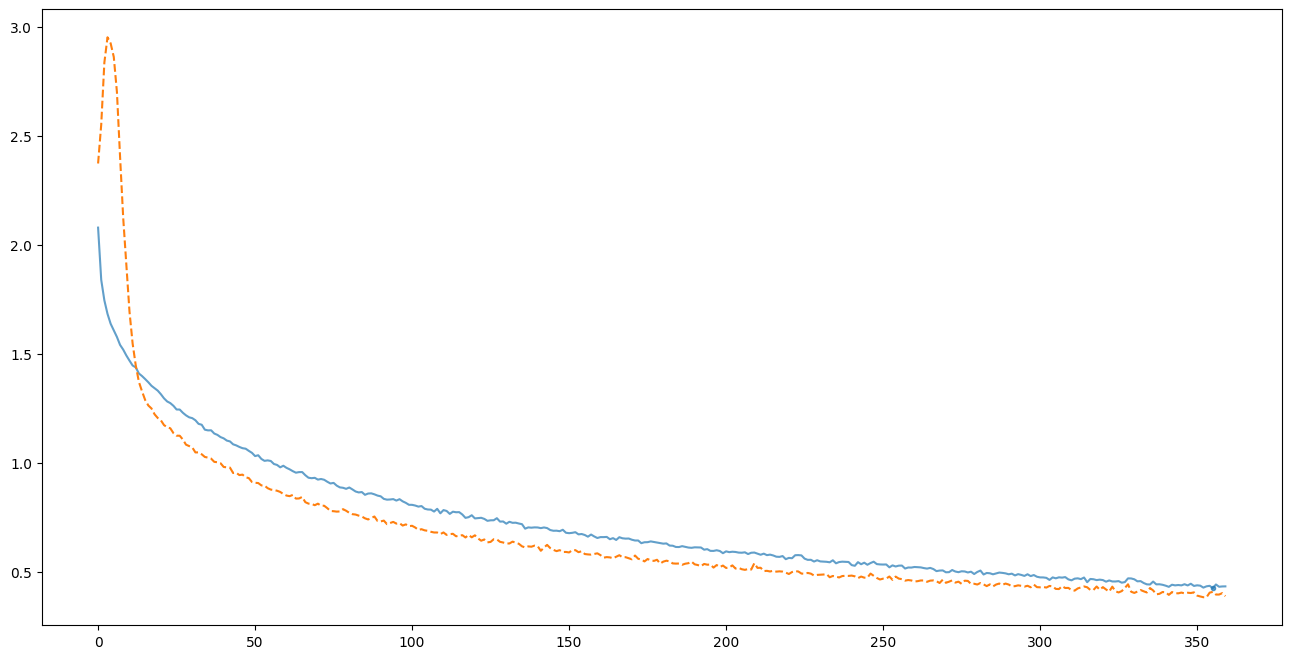

In [20]:
helpers.plot_train_history(history, x_ticks_vertical=True)

Although the shape of the curves are similar to the ones of the previous experiment, the generalization gap is thinner. If we look at the error minimums we also find out that there is a smaller difference between validation and train errors.<br/>
<br/>

### 3. Model evaluation


#### * Register model output

In [21]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

C:\Users\angel\AppData\Local\Temp\ipykernel_9908\1987032789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['pred'] = yhat_probs


#### 3.1 Confussion matrix

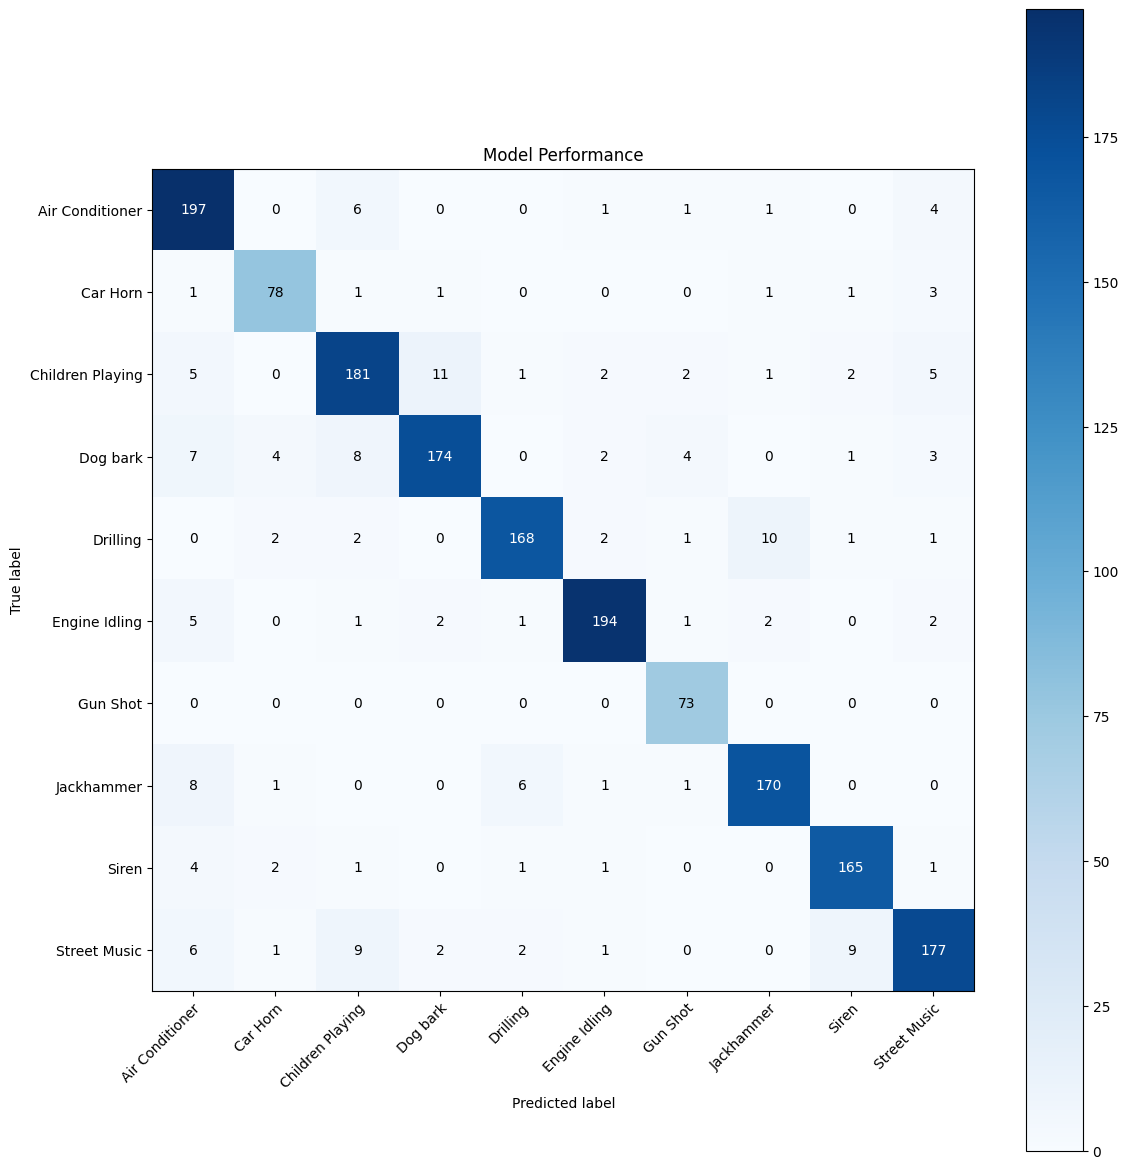

In [22]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

The patterns found on working with MFCC are replicated, but most of the true positives have increased and false negatives have decreased.<br/>
<br/>

#### 3.2 Accuracy table

In [23]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,100.000000
8,Siren,94.285714
0,Air Conditioner,93.809524
5,Engine Idling,93.269231
7,Jackhammer,90.909091
1,Car Horn,90.697674
4,Drilling,89.839572
2,Children Playing,86.190476
3,Dog bark,85.714286
9,Street Music,85.507246


In a similar fashion, most class-accuracies have increased.

#### 3.3 Classification performance: Presicion, Recall and F1 scores

In [24]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.85      0.94      0.89       210
        Car Horn       0.89      0.91      0.90        86
Children Playing       0.87      0.86      0.86       210
        Dog bark       0.92      0.86      0.89       203
        Drilling       0.94      0.90      0.92       187
   Engine Idling       0.95      0.93      0.94       208
        Gun Shot       0.88      1.00      0.94        73
      Jackhammer       0.92      0.91      0.91       187
           Siren       0.92      0.94      0.93       175
    Street Music       0.90      0.86      0.88       207

        accuracy                           0.90      1746
       macro avg       0.90      0.91      0.91      1746
    weighted avg       0.90      0.90      0.90      1746



Scores have increased a bit in average, we still see the same general patterns.
<br/>

### 4. Conclusions

Log scaled Mel Spectrograms did work better than MFCC coefficients in our experiments, as it also happened in some of the papers I referenced. On a different experiment I also used **128** MEL bands (the usual number of bands used on papers that use Mel Spectrograms), in my particular case I didn't notice a difference that could justify processing so many more channels (+88) per sample.<br/>
<br/> 

### 5. Next

We already found out that Mel Spectrograms features work better, now we want to see how much this model can improve if we use augmented data.<br/>
<br/>
<br/>